## Title: West Nile Virus in Mosquitoes across the City of Chicago Prediction
### Author: Yang, Gao
### Time: June 23, 2018

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import StratifiedShuffleSplit,train_test_split
from sklearn import decomposition,linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier,Lasso,LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,f1_score,roc_auc_score,precision_recall_curve,roc_curve,auc
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
import gmplot
%matplotlib inline
#using matplotlib’s ggplot style
plt.style.use('ggplot')
import seaborn as sns

/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Dataset


In [2]:
path ='/Users/gyang/Desktop/data_interview/kaggle/data/'

In [3]:
# Load dataset 
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
weather =pd.read_csv(path+'weather.csv')
spray =pd.read_csv(path+'spray.csv')

In [4]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [5]:
print(train[['Date']].min())
print(train[['Date']].max())

Date    2007-05-29
dtype: object
Date    2013-09-26
dtype: object


In [6]:
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [7]:
print(test[['Date']].min())
print(test[['Date']].max())

Date    2008-06-11
dtype: object
Date    2014-10-02
dtype: object


In [8]:
# spray data cannot cover the whole train and test dataframe
# could not use spray data to make further consideration
# need to find other resources about spray dataset

print(spray[['Date']].min())
print(spray[['Date']].max())

Date    2011-08-29
dtype: object
Date    2013-09-05
dtype: object


In [9]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


## Data Visualization


In [10]:
edv =train.copy()

In [11]:
#Select YYYY-MM (Year_Month)
edv['Year_Month'] = edv['Date'].apply(lambda x: str(x)[:7])
edv['Month'] = edv['Date'].apply(lambda x: str(x)[5:7]) 
edv['Day'] = edv['Date'].apply(lambda x: str(x)[8:])

def species(x):
    if x =='CULEX PIPIENS/RESTUANS':
        return 0
    elif x =='CULEX RESTUANS':
        return 1
    elif x =='CULEX PIPIENS':
        return 2
    elif x =='CULEX TERRITANS':
        return 3
    elif x =='CULEX SALINARIUS':
        return 4
    elif x =='CULEX TARSALIS':
        return 5
    else:
        return 6
    
edv['typeSpecies'] =edv['Species'].apply(lambda x : species(x))
edv['typeSpecies'] = edv['typeSpecies'].astype('object')

le = preprocessing.LabelEncoder()

#train4[CAT_COLUMNS] = le.fit_transform(train4[CAT_COLUMNS])
#train4[CAT_COLUMNS] = train4[CAT_COLUMNS].astype('object')

edv['Trap'] = le.fit_transform(edv['Trap'])
edv['Trap'] = edv['Trap'].astype('object')

edv['Street'] = le.fit_transform(edv['Street'])
edv['Street'] = edv['Street'].astype('object')

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

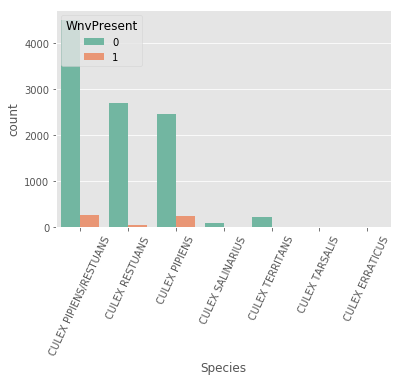

In [12]:
sns.countplot(x="Species",hue="WnvPresent", data=train,palette="Set2")
plt.xticks(rotation=65)
#plt.legend(loc='upper right')

In [13]:
edv2 = pd.DataFrame({'Total_Mosquitos' : edv.groupby(['Date'])['NumMosquitos'].sum()}).reset_index()
edv3 = pd.DataFrame({'Total_WnvPresent' : edv.groupby(['Date'])['WnvPresent'].sum()}).reset_index()
edv4 = pd.DataFrame({'Total_WnvPresent' : edv.groupby(['Month'])['WnvPresent'].sum()}).reset_index()
edv5 = pd.DataFrame({'Total_Mosquitos' : edv.groupby(['Month'])['NumMosquitos'].sum()}).reset_index()
edv6 = edv.drop(['Date','Address','Species','AddressNumberAndStreet','Year_Month'], axis=1)
edv7 = pd.DataFrame({'Total_WnvPresent' : edv.groupby(['Year_Month'])['WnvPresent'].sum()}).reset_index()
edv8 = pd.DataFrame({'Total_Mosquitos' : edv.groupby(['Year_Month'])['NumMosquitos'].sum()}).reset_index()

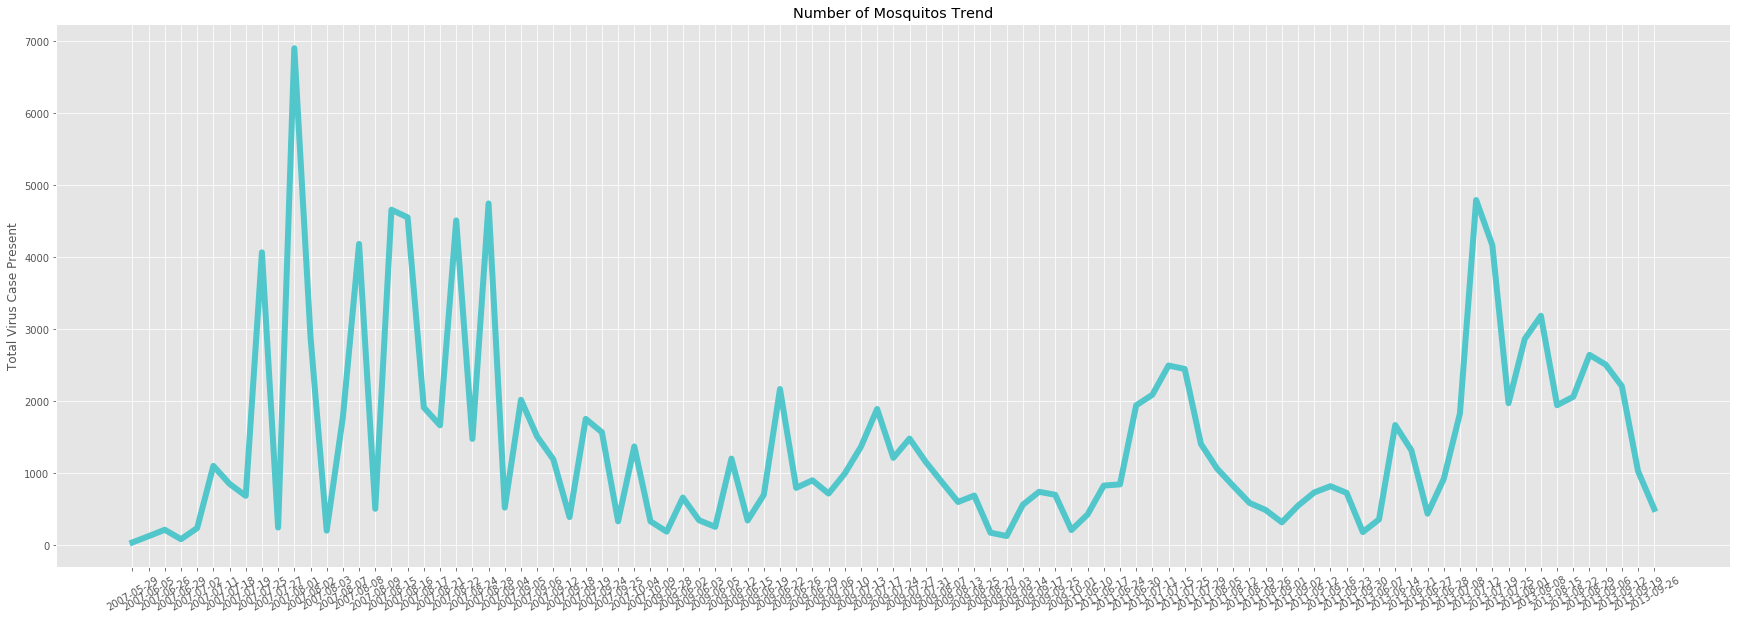

In [14]:
plt.figure(figsize=(30,10))
plt.plot_date(x=edv2['Date'], y=edv2['Total_Mosquitos'], fmt="#51C7CB",linewidth=6)
plt.title("Number of Mosquitos Trend")
plt.ylabel("Total Virus Case Present")
plt.xticks(rotation=30)
plt.grid(True)
#plt.show()

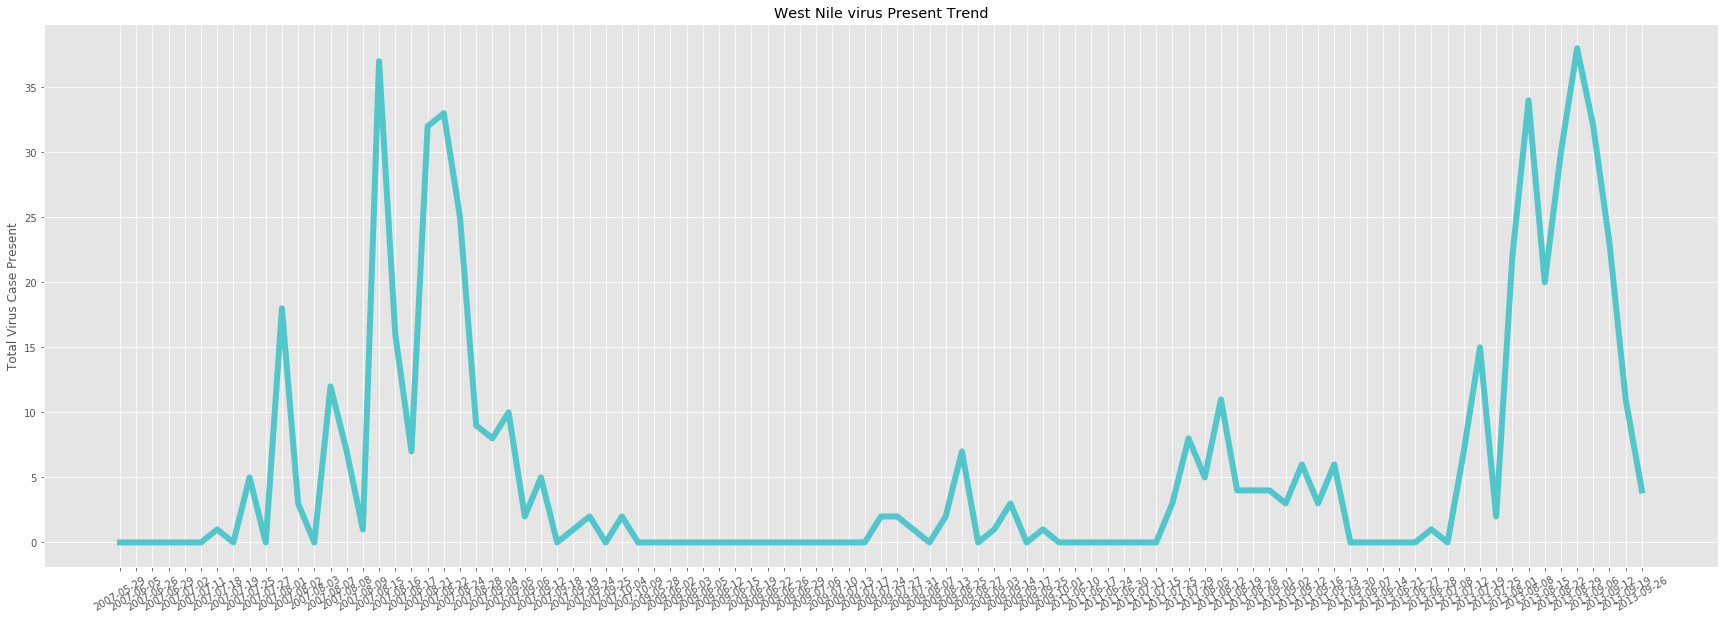

In [15]:
plt.figure(figsize=(30,10))
plt.plot_date(x=edv3['Date'], y=edv3['Total_WnvPresent'], fmt="#51C7CB",linewidth=6)
plt.title("West Nile virus Present Trend")
plt.ylabel("Total Virus Case Present")
plt.xticks(rotation=30)
plt.grid(True)
#plt.show()

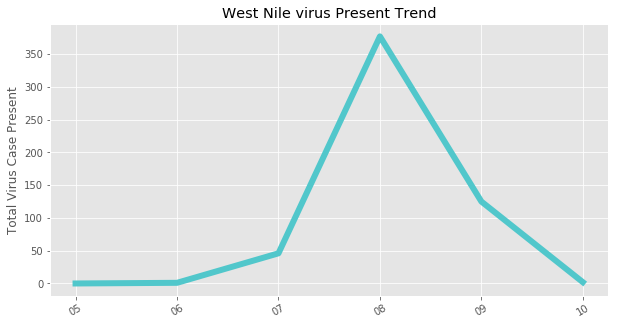

In [16]:
plt.figure(figsize=(10,5))
plt.plot_date(x=edv4['Month'], y=edv4['Total_WnvPresent'], fmt="#51C7CB",linewidth=6)
plt.title("West Nile virus Present Trend")
plt.ylabel("Total Virus Case Present")
plt.xticks(rotation=30)
plt.grid(True)
#plt.show()

WBV virus spreads out during the summer time from June to Sep.I could image time (month and day) will be a correlation with WNV Present.There is no statistical significant correlation between number of Mosquitos and WNV present.

In [17]:
import scipy

#spearman
scipy.stats.stats.spearmanr(edv['NumMosquitos'],edv['WnvPresent'])[0]

0.20469632782239508

In [18]:
edv6_1 =pd.get_dummies(edv6, columns =['typeSpecies','Month'])

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5]),
 <a list of 19 Text xticklabel objects>)

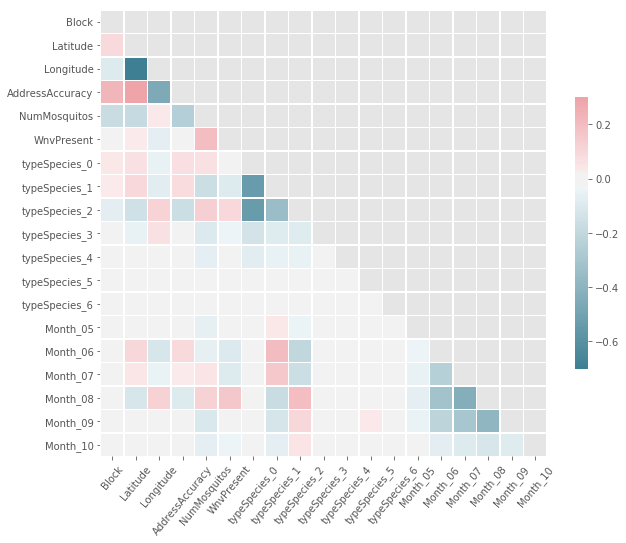

In [19]:
# Compute the correlation matrix
corr_edv = edv6_1.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_edv, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_edv, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=50)

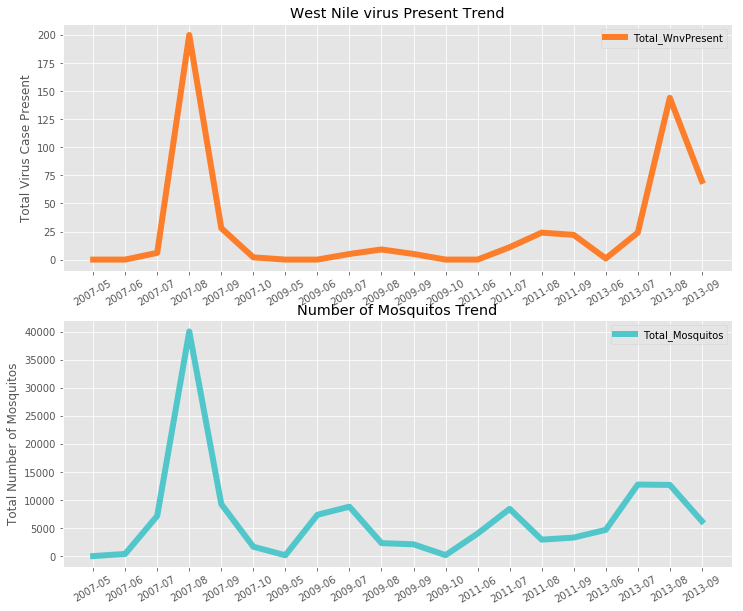

In [20]:
fig = plt.figure(figsize=(12,10))

plt.subplot(2,1, 1)
plt.plot_date(x=edv7['Year_Month'], y=edv7['Total_WnvPresent'], fmt="#FC7E2A",linewidth=6)
plt.title("West Nile virus Present Trend")
plt.ylabel("Total Virus Case Present")
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()
#plt.show()

plt.subplot(2,1, 2)
plt.plot_date(x=edv8['Year_Month'], y=edv8['Total_Mosquitos'], fmt="#51C7CB",linewidth=6)
plt.title("Number of Mosquitos Trend")
plt.ylabel("Total Number of Mosquitos")
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

#plt.show()

Text(0,0.5,'# WnvPresent')

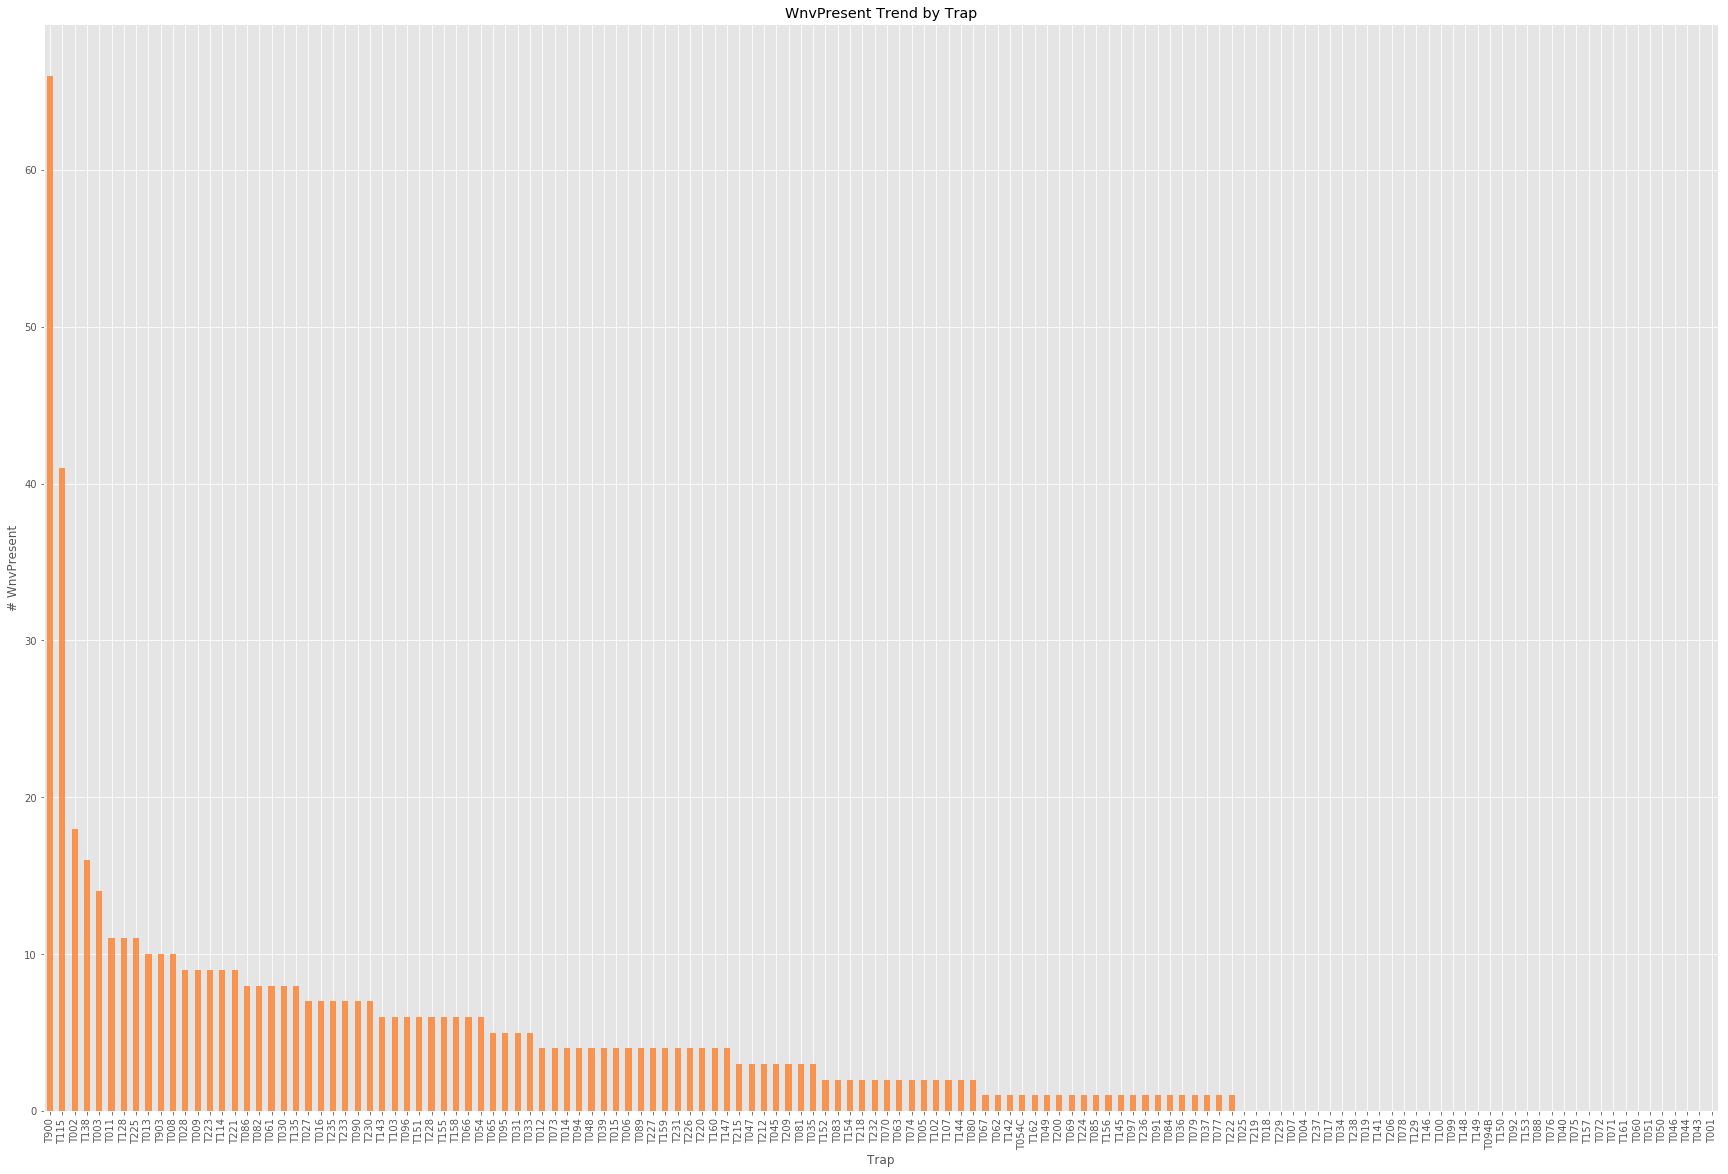

In [30]:
fig = plt.figure(figsize=(30,20))

train.groupby('Trap')['WnvPresent'].sum().sort_values(ascending =False).plot.bar(color="#FC7E2A",alpha=0.8)
plt.title("WnvPresent Trend by Trap")
plt.ylabel("# WnvPresent")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

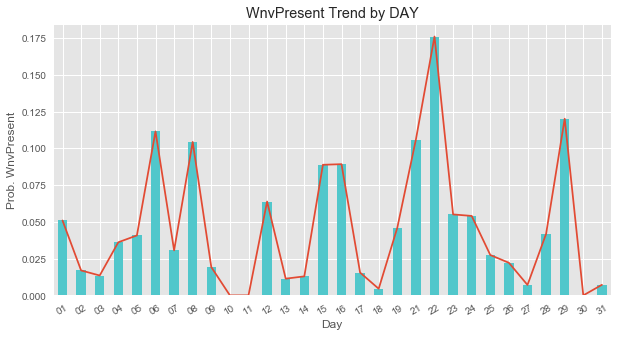

In [938]:
fig = plt.figure(figsize=(10,5))
edv.groupby('Day')['WnvPresent'].mean().plot.bar(color="#51C7CB")
edv.groupby('Day')['WnvPresent'].mean().plot()
plt.title("WnvPresent Trend by DAY")
plt.ylabel("Prob. WnvPresent")
plt.xticks(rotation=30)

In [932]:
#build heatmap
edv_map =edv.loc[edv['NumMosquitos'] >0]

In [212]:
lat = edv_map["Latitude"]
lon = edv_map["Longitude"]

lat_m =edv.loc[edv['WnvPresent'] ==1]["Latitude"]
lon_m =edv.loc[edv['WnvPresent'] ==1]["Longitude"]

lat_s1 =edv.loc[edv['Species'] =='CULEX PIPIENS/RESTUANS']["Latitude"]
lon_s1 =edv.loc[edv['Species'] =='CULEX PIPIENS/RESTUANS']["Longitude"]

lat_s2 =edv.loc[edv['Species'] =='CULEX RESTUANS']["Latitude"]
lon_s2 =edv.loc[edv['Species'] =='CULEX RESTUANS']["Longitude"]

lat_s3 =edv.loc[edv['Species'] =='CULEX PIPIENS']["Latitude"]
lon_s3 =edv.loc[edv['Species'] =='CULEX PIPIENS']["Longitude"]

lat_s4 =edv.loc[edv['Species'] =='CULEX TERRITANS']["Latitude"]
lon_s4 =edv.loc[edv['Species'] =='CULEX TERRITANS']["Longitude"]

lat_s5 =edv.loc[edv['Species'] =='CULEX SALINARIUS']["Latitude"]
lon_s5 =edv.loc[edv['Species'] =='CULEX SALINARIUS']["Longitude"]

lat_s6 =edv.loc[edv['Species'] =='CULEX TARSALIS']["Latitude"]
lon_s6 =edv.loc[edv['Species'] =='CULEX TARSALIS']["Longitude"]

lat_s7 =edv.loc[edv['Species'] =='CULEX ERRATICUS']["Latitude"]
lon_s7 =edv.loc[edv['Species'] =='CULEX ERRATICUS']["Longitude"]

lat_sp = spray["Latitude"]
lon_sp = spray["Longitude"]

In [239]:
lat_limit =edv.loc[(edv['Date'] >= '2011-01-01' )& (edv['Date'] <= '2013-12-31')]["Latitude"]
lon_limit =edv.loc[(edv['Date'] >= '2011-01-01' )& (edv['Date'] <= '2013-12-31')]["Longitude"]

In [947]:
gmap = gmplot.GoogleMapPlotter(41.881832, -87.623177,15)
gmap.heatmap(lat, lon)
gmap.marker(41.995, -87.933, 'cornflowerblue') #station 1
gmap.marker(41.786, -87.752, 'cornflowerblue') #station 2
gmap.scatter(lat, lon, '#8F4EF2', size=300, marker=False)
gmap.scatter(lat_m, lon_m, '#ECF24E', size=800,marker=False)
gmap.scatter(lat_sp, lon_sp, '#F24EE7', size=100,marker=False)
gmap.draw('map.html')

In [224]:
gmap2 = gmplot.GoogleMapPlotter(41.881832, -87.623177,15)
gmap2.heatmap(lat_m, lon_m)
gmap2.scatter(lat_s1, lon_s1, '#F24E8A', size=100, marker=False)
gmap2.scatter(lat_s2, lon_s2, '#F24EE7', size=200,marker=False)
gmap2.scatter(lat_s3, lon_s3, '#954EF2', size=300, marker=False)
gmap2.scatter(lat_s4, lon_s4, '#4EF28A', size=400,marker=False)
gmap2.scatter(lat_s5, lon_s5, '#4EE7F2', size=500, marker=False)
gmap2.scatter(lat_s6, lon_s6, '#E7F24E', size=600,marker=False)
gmap2.scatter(lat_s7, lon_s7, '#F2594E', size=700, marker=False)
#gmap2.scatter(lat_m, lon_m, 'k',marker=True)
gmap2.draw('map2.html')

## Data Cleaning

In [23]:
train.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object

In [24]:
#target label
train['WnvPresent'].value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

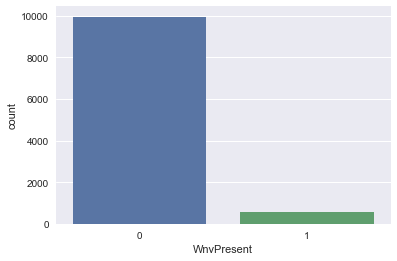

In [25]:
sns.countplot(x="WnvPresent", data=train)

In [26]:
#type of species
train['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

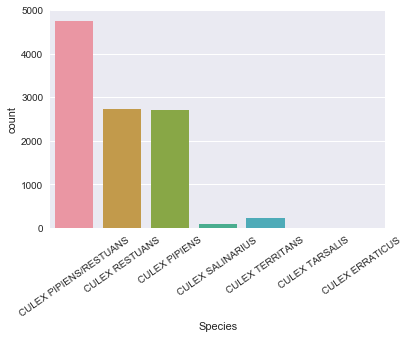

In [27]:
sns.countplot(x="Species", data=train)
plt.xticks(rotation=35)

In [28]:
#check missing value train 
#categorical features
miss_category_tr = train.select_dtypes(include=['object'])
miss_cate_rate_tr = miss_category_tr.isnull().sum(axis =0)/float(len(miss_category_tr))
miss_cate_rate_tr.sort_values(ascending=False)

AddressNumberAndStreet    0.0
Trap                      0.0
Street                    0.0
Species                   0.0
Address                   0.0
Date                      0.0
dtype: float64

In [29]:
# check numerical features train
miss_numerical_tr = train.select_dtypes(exclude=['object'])
miss_num_rate_tr = miss_numerical_tr.isnull().sum(axis =0)/float(len(miss_numerical_tr))
miss_num_rate_tr.sort_values(ascending=False)

WnvPresent         0.0
NumMosquitos       0.0
AddressAccuracy    0.0
Longitude          0.0
Latitude           0.0
Block              0.0
dtype: float64

In [30]:
def species(x):
    if x =='CULEX PIPIENS/RESTUANS':
        return 0
    elif x =='CULEX RESTUANS':
        return 1
    elif x =='CULEX PIPIENS':
        return 2
    elif x =='CULEX TERRITANS':
        return 3
    elif x =='CULEX SALINARIUS':
        return 4
    elif x =='CULEX TARSALIS':
        return 5
    else:
        return 6

In [31]:
train['typeSpecies'] =train['Species'].apply(lambda x : species(x))
train['typeSpecies'] = train['typeSpecies'].astype('object')

train['Block'] = train['Block'].astype('object') #convert block to categorical

#drop feature
train2 =train.drop(['Species','Address','AddressNumberAndStreet','Street'],1)

In [32]:
#final clean data - train
train2.head()

,Date,Block,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,typeSpecies
0,2007-05-29,41,T002,41.954690,-87.800991,9,1,0,0
1,2007-05-29,41,T002,41.954690,-87.800991,9,1,0,1
2,2007-05-29,62,T007,41.994991,-87.769279,9,1,0,1
3,2007-05-29,79,T015,41.974089,-87.824812,8,1,0,0
4,2007-05-29,79,T015,41.974089,-87.824812,8,4,0,1


In [33]:
train2.shape

(10506, 9)

### Test data

In [34]:
#check missing value -test data
#categorical features
miss_category_te = test.select_dtypes(include=['object'])
miss_cate_rate_te = miss_category_te.isnull().sum(axis =0)/float(len(miss_category_te))
miss_cate_rate_te.sort_values(ascending=False)

AddressNumberAndStreet    0.0
Trap                      0.0
Street                    0.0
Species                   0.0
Address                   0.0
Date                      0.0
dtype: float64

In [35]:
# check numerical features -test data
miss_numerical_te = test.select_dtypes(exclude=['object'])
miss_num_rate_te = miss_numerical_te.isnull().sum(axis =0)/float(len(miss_numerical_te))
miss_num_rate_te.sort_values(ascending=False)

AddressAccuracy    0.0
Longitude          0.0
Latitude           0.0
Block              0.0
Id                 0.0
dtype: float64

In [36]:
test['typeSpecies'] =test['Species'].apply(lambda x : species(x))
test['typeSpecies'] = test['typeSpecies'].astype('object')

test['Block'] = test['Block'].astype('object') #convert block to categorical

#drop feature
test2 =test.drop(['Species','Address','AddressNumberAndStreet','Street'],1)

## Change features in weather data

M -Missing value <br/>
T -Trace<br/>

**Station 1:** CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level <br/>
**Station 2:** CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

### Numerical :

Heat -- HEATING (SEASON BEGINS WITH JULY) <br/>
Cool -- COOLING (SEASON BEGINS WITH JANUARY) <br/>
Depart -- TEMPERATURE DEPARTURE FROM NORMAL <br/>
Depth -- Max 24 hrs snow depth <br/>
Water1 -- WATER EQUIVALENT <br/>
SnowFall -- SNOWFALL(INCHES AND TENTHS) T = TRACE ,M = MISSING DATA <br/>
PrecipTotal -- Total Precipitation(inches) <br/>
SeaLevel -- AVERAGE SEA LEVEL PRESSURE  <br/>
AvgSpeed -- AVERAGE SPEED <br/>
ResultDir -- RESULTANT DIRECTION <br/>
ResultSpeed -- RESULTANT WIND SPEED<br/>
WebBulb -- wet bulb temperatures 

Tmax, Tmin, Tavg, DewPoint  ,WetBulb ,Depart ,Depth ,PrecipTotal ,StnPressure ,SeaLevel ,ResultSpeed ,ResultDir ,AvgSpeed ,Water1 ,SnowFall ,Heat ,Cool

### Categorical :
Sunrise ,Sunset ,CodeSum




In [37]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [38]:
weather1 =weather.copy()

In [39]:
#convert into float
def conv_float(x):
    for i in x:
        weather1[x] = weather1[x].astype('float64')

#convert into int        
def conv_int(x):
    for i in x:
        weather1[x] = weather1[x].astype('int64')
        
#convert into categorical
def conv_cat(x):
    for i in x:
        weather1[x] = weather1[x].astype('object')

In [40]:
#replace missing and trace value into -1
weather1 = weather1.replace('M', -999)
weather1 = weather1.replace('T', -999)
weather1 = weather1.replace(' T', -999)
weather1 = weather1.replace('  T', -999)
weather1 = weather1.replace('-', np.nan)
weather1['CodeSum'] =weather1['CodeSum'].replace(' ', np.nan)

In [41]:
float_list =['SnowFall','PrecipTotal','StnPressure','SeaLevel','ResultSpeed','AvgSpeed','Water1']
int_list =['Tmax','Tmin','Tavg','Depart','DewPoint','WetBulb','Heat','Cool','Depth','ResultDir']
cat_list =['Sunrise','Sunset','CodeSum']

In [42]:
conv_float(float_list)
conv_int(int_list)
conv_cat(cat_list)

In [43]:
weather1.dtypes

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg             int64
Depart           int64
DewPoint         int64
WetBulb          int64
Heat             int64
Cool             int64
Sunrise         object
Sunset          object
CodeSum         object
Depth            int64
Water1         float64
SnowFall       float64
PrecipTotal    float64
StnPressure    float64
SeaLevel       float64
ResultSpeed    float64
ResultDir        int64
AvgSpeed       float64
dtype: object

In [44]:
weather1.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,NaN,0,-999.0,0.0,0.0,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,-999,51,57,0,3,...,NaN,-999,-999.0,-999.0,0.0,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,-999.0,0.0,0.0,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,-999,42,47,13,0,...,BR HZ,-999,-999.0,-999.0,0.0,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,NaN,0,-999.0,0.0,0.0,29.39,30.12,11.7,7,11.9


In [439]:
weather_s1 = weather1[weather1['Station']==1]
weather_s2 = weather1[weather1['Station']==2]
weather_s1 = weather_s1.drop('Station', axis=1)
weather_s2 = weather_s2.drop('Station', axis=1)
weather2 = weather_s1.merge(weather_s2, on='Date')

In [443]:
#check missing value -weather data
#categorical features
miss_category_w = weather2.select_dtypes(include=['object'])
miss_cate_rate_w = miss_category_w.isnull().sum(axis =0)/float(len(miss_category_w))
miss_cate_rate_w.sort_values(ascending =False)

Sunset_y     1.000000
Sunrise_y    1.000000
CodeSum_x    0.546875
CodeSum_y    0.546196
Sunset_x     0.000000
Sunrise_x    0.000000
Date         0.000000
dtype: float64

In [444]:
#drop missing value >=50%
weather3 =weather2.drop(miss_cate_rate_w[miss_cate_rate_w >=0.5].index, axis=1, inplace=False)

In [445]:
weather3.head()

,Date,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,...,Cool_y,Depth_y,Water1_y,SnowFall_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,2007-05-01,83,50,67,14,51,56,0,2,0448,...,3,-999,-999.0,-999.0,0.0,29.18,29.82,2.7,25,9.6
1,2007-05-02,59,42,51,-3,42,47,14,0,0447,...,0,-999,-999.0,-999.0,0.0,29.44,30.08,13.3,2,13.4
2,2007-05-03,66,46,56,2,40,48,9,0,0446,...,0,-999,-999.0,-999.0,0.0,29.46,30.12,12.9,6,13.2
3,2007-05-04,66,49,58,4,41,50,7,0,0444,...,-999,-999,-999.0,-999.0,0.0,29.36,30.04,10.1,7,10.4
4,2007-05-05,66,53,60,5,38,49,5,0,0443,...,0,-999,-999.0,-999.0,-999.0,29.46,30.09,11.2,7,11.5


In [446]:
weather4 = weather3.replace(-999, np.nan)

In [447]:
# check numerical features - weather data
miss_numerical_w = weather4.select_dtypes(exclude=['object'])
miss_num_rate_w = miss_numerical_w.isnull().sum(axis =0)/float(len(miss_numerical_w))
miss_num_rate_w.sort_values(ascending=False)

Water1_x         1.000000
SnowFall_y       1.000000
Water1_y         1.000000
Depth_y          1.000000
Depart_y         1.000000
PrecipTotal_x    0.110734
PrecipTotal_y    0.106658
SnowFall_x       0.008152
Tavg_y           0.007473
Cool_y           0.007473
Heat_y           0.007473
SeaLevel_x       0.003397
SeaLevel_y       0.002717
WetBulb_x        0.002038
AvgSpeed_y       0.002038
StnPressure_x    0.001359
StnPressure_y    0.001359
WetBulb_y        0.000679
Depart_x         0.000000
DewPoint_x       0.000000
Depth_x          0.000000
Heat_x           0.000000
Cool_x           0.000000
Tmin_x           0.000000
Tavg_x           0.000000
AvgSpeed_x       0.000000
ResultSpeed_x    0.000000
ResultDir_x      0.000000
ResultDir_y      0.000000
Tmax_y           0.000000
Tmin_y           0.000000
DewPoint_y       0.000000
ResultSpeed_y    0.000000
Tmax_x           0.000000
dtype: float64

In [768]:
#drop missing value >=50%
weather5 =weather4.drop(miss_num_rate_w[miss_num_rate_w >=0.5].index, axis=1, inplace=False)

In [769]:
weather5.head()

,Date,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,...,DewPoint_y,WetBulb_y,Heat_y,Cool_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,2007-05-01,83,50,67,14,51,56.0,0,2,0448,...,51,57.0,0.0,3.0,0.0,29.18,29.82,2.7,25,9.6
1,2007-05-02,59,42,51,-3,42,47.0,14,0,0447,...,42,47.0,13.0,0.0,0.0,29.44,30.08,13.3,2,13.4
2,2007-05-03,66,46,56,2,40,48.0,9,0,0446,...,40,50.0,7.0,0.0,0.0,29.46,30.12,12.9,6,13.2
3,2007-05-04,66,49,58,4,41,50.0,7,0,0444,...,42,50.0,NaN,NaN,0.0,29.36,30.04,10.1,7,10.4
4,2007-05-05,66,53,60,5,38,49.0,5,0,0443,...,39,50.0,5.0,0.0,NaN,29.46,30.09,11.2,7,11.5


In [770]:
def fillin_mean(x):
    for i in x:
        weather5[x] = weather5[x].fillna((weather5[x].mean()))
    

In [771]:
fillin_list =['PrecipTotal_x','PrecipTotal_y','SnowFall_x','Tavg_y','Cool_y',
             'Heat_y','SeaLevel_x','SeaLevel_y','WetBulb_x','AvgSpeed_y',
              'StnPressure_x','StnPressure_y','WetBulb_y']

In [772]:
fillin_mean(fillin_list)

In [773]:
weather5.head()

,Date,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,...,DewPoint_y,WetBulb_y,Heat_y,Cool_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,2007-05-01,83,50,67,14,51,56.0,0,2,0448,...,51,57.0,0.000000,3.000000,0.000000,29.18,29.82,2.7,25,9.6
1,2007-05-02,59,42,51,-3,42,47.0,14,0,0447,...,42,47.0,13.000000,0.000000,0.000000,29.44,30.08,13.3,2,13.4
2,2007-05-03,66,46,56,2,40,48.0,9,0,0446,...,40,50.0,7.000000,0.000000,0.000000,29.46,30.12,12.9,6,13.2
3,2007-05-04,66,49,58,4,41,50.0,7,0,0444,...,42,50.0,3.181383,6.059548,0.000000,29.36,30.04,10.1,7,10.4
4,2007-05-05,66,53,60,5,38,49.0,5,0,0443,...,39,50.0,5.000000,0.000000,0.143217,29.46,30.09,11.2,7,11.5


In [774]:
weather5.columns.values

array(['Date', 'Tmax_x', 'Tmin_x', 'Tavg_x', 'Depart_x', 'DewPoint_x',
       'WetBulb_x', 'Heat_x', 'Cool_x', 'Sunrise_x', 'Sunset_x', 'Depth_x',
       'SnowFall_x', 'PrecipTotal_x', 'StnPressure_x', 'SeaLevel_x',
       'ResultSpeed_x', 'ResultDir_x', 'AvgSpeed_x', 'Tmax_y', 'Tmin_y',
       'Tavg_y', 'DewPoint_y', 'WetBulb_y', 'Heat_y', 'Cool_y',
       'PrecipTotal_y', 'StnPressure_y', 'SeaLevel_y', 'ResultSpeed_y',
       'ResultDir_y', 'AvgSpeed_y'], dtype=object)

### Try to deal with Circular Variable (e.g. Sunrise /Sunset)
Reference: <br/>
[Is hour of day a categorical variable?](https://stats.stackexchange.com/questions/245866/is-hour-of-day-a-categorical-variable)<br/>
[Regression using circular variable (hour from 0~23) as predictor](https://stats.stackexchange.com/questions/336613/regression-using-circular-variable-hour-from-023-as-predictor?rq=1)

In [775]:
weather5['Sunrise'] = weather5['Sunrise_x'].apply(lambda x: str(x)[:2]).astype(float) + weather5['Sunrise_x'].apply(lambda x: str(x)[2:]).astype(float)/60
weather5['Sunset'] = weather5['Sunset_x'].apply(lambda x: str(x)[:2]).astype(float) + weather5['Sunset_x'].apply(lambda x: str(x)[2:]).astype(float)/60

In [776]:
weather5['xhr_sunrise'] = np.sin(2*np.pi*weather5['Sunrise']/24).astype(float)
weather5['yhr_sunrise'] = np.cos(2*np.pi*weather5['Sunrise']/24).astype(float)

weather5['xhr_sunset'] = np.sin(2*np.pi*weather5['Sunset']/24).astype(float)
weather5['yhr_sunset'] = np.cos(2*np.pi*weather5['Sunset']/24).astype(float)

In [777]:
weather6 =weather5.drop(['Sunrise_x', 'Sunset_x','Sunrise','Sunset'],1)

In [778]:
weather6.head()

,Date,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Depth_x,...,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y,xhr_sunrise,yhr_sunrise,xhr_sunset,yhr_sunset
0,2007-05-01,83,50,67,14,51,56.0,0,2,0,...,0.000000,29.18,29.82,2.7,25,9.6,0.951057,0.309017,-0.977231,0.212178
1,2007-05-02,59,42,51,-3,42,47.0,14,0,0,...,0.000000,29.44,30.08,13.3,2,13.4,0.949699,0.313164,-0.976296,0.216440
2,2007-05-03,66,46,56,2,40,48.0,9,0,0,...,0.000000,29.46,30.12,12.9,6,13.2,0.948324,0.317305,-0.975342,0.220697
3,2007-05-04,66,49,58,4,41,50.0,7,0,0,...,0.000000,29.36,30.04,10.1,7,10.4,0.945519,0.325568,-0.974370,0.224951
4,2007-05-05,66,53,60,5,38,49.0,5,0,0,...,0.143217,29.46,30.09,11.2,7,11.5,0.944089,0.329691,-0.973379,0.229200


### New Train Data Transform

#### train.csv + weather.csv

In [780]:
#train2 + weather6 (inner join)
train3 = train2.merge(weather6, on='Date')

In [781]:
train3.shape

(10506, 42)

In [748]:
train3.head()

,Date,Block,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,typeSpecies,Tmax_x,...,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y,xhr_sunrise,yhr_sunrise,xhr_sunset,yhr_sunset
0,2007-05-29,41,T002,41.954690,-87.800991,9,1,0,0,88,...,0.0,29.44,30.09,5.8,16,7.4,0.908143,0.41866,-0.944089,0.329691
1,2007-05-29,41,T002,41.954690,-87.800991,9,1,0,1,88,...,0.0,29.44,30.09,5.8,16,7.4,0.908143,0.41866,-0.944089,0.329691
2,2007-05-29,62,T007,41.994991,-87.769279,9,1,0,1,88,...,0.0,29.44,30.09,5.8,16,7.4,0.908143,0.41866,-0.944089,0.329691
3,2007-05-29,79,T015,41.974089,-87.824812,8,1,0,0,88,...,0.0,29.44,30.09,5.8,16,7.4,0.908143,0.41866,-0.944089,0.329691
4,2007-05-29,79,T015,41.974089,-87.824812,8,4,0,1,88,...,0.0,29.44,30.09,5.8,16,7.4,0.908143,0.41866,-0.944089,0.329691


In [749]:
train3['Month'] = train3['Date'].apply(lambda x: str(x)[5:7])
train3['Day'] = train3['Date'].apply(lambda x: str(x)[8:])

train3['Month'] = train3['Month'].astype('category')
train3['Day'] = train3['Day'].astype('category')

In [750]:
train3.head()

,Date,Block,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,typeSpecies,Tmax_x,...,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y,xhr_sunrise,yhr_sunrise,xhr_sunset,yhr_sunset,Month,Day
0,2007-05-29,41,T002,41.954690,-87.800991,9,1,0,0,88,...,30.09,5.8,16,7.4,0.908143,0.41866,-0.944089,0.329691,05,29
1,2007-05-29,41,T002,41.954690,-87.800991,9,1,0,1,88,...,30.09,5.8,16,7.4,0.908143,0.41866,-0.944089,0.329691,05,29
2,2007-05-29,62,T007,41.994991,-87.769279,9,1,0,1,88,...,30.09,5.8,16,7.4,0.908143,0.41866,-0.944089,0.329691,05,29
3,2007-05-29,79,T015,41.974089,-87.824812,8,1,0,0,88,...,30.09,5.8,16,7.4,0.908143,0.41866,-0.944089,0.329691,05,29
4,2007-05-29,79,T015,41.974089,-87.824812,8,4,0,1,88,...,30.09,5.8,16,7.4,0.908143,0.41866,-0.944089,0.329691,05,29


In [751]:
train4 =train3.drop(['Date','NumMosquitos'],1)

In [752]:
#one hot encoding

CAT_COLUMNS =['Block','Trap','typeSpecies','Month','Day']

train4 =pd.get_dummies(train4, columns =CAT_COLUMNS)

train4['WnvPresent'] = train4['WnvPresent'].astype('category')

#numerical feature scaling
scaler = MinMaxScaler()
NUM_COLUMNS = list(train4.select_dtypes(exclude=['object','category']).columns)
train4[NUM_COLUMNS] = scaler.fit_transform(train4[NUM_COLUMNS])

In [753]:
train4.head()

,Latitude,Longitude,AddressAccuracy,WnvPresent,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,...,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31
0,0.831714,0.325531,1.000000,0,0.794872,0.542857,0.705882,0.733333,0.558824,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.831714,0.325531,1.000000,0,0.794872,0.542857,0.705882,0.733333,0.558824,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.939812,0.404938,1.000000,0,0.794872,0.542857,0.705882,0.733333,0.558824,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.883748,0.265883,0.833333,0,0.794872,0.542857,0.705882,0.733333,0.558824,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.883748,0.265883,0.833333,0,0.794872,0.542857,0.705882,0.733333,0.558824,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### NEW Test Data Transform

In [612]:
#test2 + weather6 (inner join)
#test data

test3 = test2.merge(weather6, on='Date')

In [613]:
test3 =test3.set_index('Id')

test3['Month'] = test3['Date'].apply(lambda x: str(x)[5:7])
test3['Day'] = test3['Date'].apply(lambda x: str(x)[8:])

test3['Month'] = test3['Month'].astype('category')
test3['Day'] = test3['Day'].astype('category')

In [614]:
test3.head()

,Date,Block,Trap,Latitude,Longitude,AddressAccuracy,typeSpecies,Tmax_x,Tmin_x,Tavg_x,...,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y,xhr_sunrise,yhr_sunrise,xhr_sunset,yhr_sunset,Month,Day
Id,,,,,,,,,,,,,,,,,,,,,
1,2008-06-11,41,T002,41.95469,-87.800991,9,0,86,61,74,...,29.97,9.4,18,10.4,0.898794,0.438371,-0.930418,0.366501,06,11
2,2008-06-11,41,T002,41.95469,-87.800991,9,1,86,61,74,...,29.97,9.4,18,10.4,0.898794,0.438371,-0.930418,0.366501,06,11
3,2008-06-11,41,T002,41.95469,-87.800991,9,2,86,61,74,...,29.97,9.4,18,10.4,0.898794,0.438371,-0.930418,0.366501,06,11
4,2008-06-11,41,T002,41.95469,-87.800991,9,4,86,61,74,...,29.97,9.4,18,10.4,0.898794,0.438371,-0.930418,0.366501,06,11
5,2008-06-11,41,T002,41.95469,-87.800991,9,3,86,61,74,...,29.97,9.4,18,10.4,0.898794,0.438371,-0.930418,0.366501,06,11


In [615]:
test4 =test3.drop(['Date'],1)

In [616]:
#one hot encode

CAT_COLUMNS =['Block','Trap','typeSpecies','Month','Day']

test4 =pd.get_dummies(test4, columns =CAT_COLUMNS)


#numerical feature scaling
scaler = MinMaxScaler()
NUM_COLUMNS = list(test4.select_dtypes(exclude=['object']).columns)
test4[NUM_COLUMNS] = scaler.fit_transform(test4[NUM_COLUMNS])

In [617]:
test4.head()

,Latitude,Longitude,AddressAccuracy,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,...,Day_21,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31
Id,,,,,,,,,,,,,,,,,,,,,
1,0.831714,0.325531,1.0,0.769231,0.52,0.7,0.678571,0.53125,0.62963,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.831714,0.325531,1.0,0.769231,0.52,0.7,0.678571,0.53125,0.62963,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.831714,0.325531,1.0,0.769231,0.52,0.7,0.678571,0.53125,0.62963,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.831714,0.325531,1.0,0.769231,0.52,0.7,0.678571,0.53125,0.62963,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.831714,0.325531,1.0,0.769231,0.52,0.7,0.678571,0.53125,0.62963,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [618]:
train4.shape

(10506, 280)

In [619]:
test4.shape

(116293, 292)

In [620]:
# Get missing columns in the training data
missing_cols_tr = set(test4.columns) - set(train4.columns)
missing_cols_tr

{'Block_26',
 'Day_20',
 'Trap_T002A',
 'Trap_T002B',
 'Trap_T065A',
 'Trap_T090A',
 'Trap_T090B',
 'Trap_T090C',
 'Trap_T128A',
 'Trap_T200A',
 'Trap_T200B',
 'Trap_T218A',
 'Trap_T218B',
 'Trap_T218C',
 'Trap_T234'}

In [621]:
# Get missing columns in the test data 
missing_cols_te = set(train4.columns) - set(test4.columns)
missing_cols_te

{'Day_22', 'Month_05', 'WnvPresent'}

In [622]:
#add missing columns in BOTH train and test dataset
train5,test5 = train4.align(test4, join='outer', axis=1, fill_value=0)

In [623]:
train5.shape

(10506, 295)

In [624]:
test5.shape

(116293, 295)

In [625]:
missing_col_check =set(train5.columns) -set(test5.columns)
missing_col_check

set()

### Split data & Build Models

In [626]:
#split data into train and valid data（20%）
sess = StratifiedShuffleSplit(train5['WnvPresent'].values, test_size = 0.2)
for train_index,valid_index in sess:
    trainData = train5.iloc[train_index]
    validData = train5.iloc[valid_index]

X_train,y_train = trainData.drop(['WnvPresent'],1) ,trainData['WnvPresent']
X_valid,y_valid = validData.drop(['WnvPresent'],1) ,validData['WnvPresent']

In [627]:
print(trainData.shape)
print(validData.shape)

(8404, 295)
(2102, 295)


In [628]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(8404, 294)
(8404,)
(2102, 294)
(2102,)


In [629]:
#imbalance label -upsampling label
sm = SMOTE(random_state=42, ratio = 1.0)

X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [630]:
print(X_train_res.shape)
print(y_train_res.shape)

(15926, 294)
(15926,)


### Logistic Regression

In [874]:
grid_lr = {'penalty': ['l1','l2'], 
           'C': [0.01,0.02]}

lr = GridSearchCV(estimator=LogisticRegression(random_state=42), param_grid=grid_lr,) 

lr.fit(X_train_res, y_train_res)
pred_lr = lr.best_estimator_.fit(X_train_res, y_train_res).predict(X_valid)

### Decision Tree

In [850]:
dt_classifer = DecisionTreeClassifier(random_state=42)

grid_dt = {
 'max_depth': [5,10,15], #30],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2 ], #, 4],
 'min_samples_split': list(range(2, 5))}

dt = GridSearchCV(estimator=dt_classifer, param_grid =grid_dt, cv=3) 

In [851]:
dt.fit(X_train_res, y_train_res)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 10, 15], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 3, 4], 'max_features': ['sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [852]:
dt.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [961]:
pred_dt = dt.best_estimator_.fit(X_train_res, y_train_res).predict(X_valid)

print('False Negative: ',confusion_matrix(y_valid, pred_dt).ravel()[2])
print('Confusion Matrix:', confusion_matrix(y_valid, pred_dt))

False Negative:  47
Confusion Matrix: [[1679  313]
 [  47   63]]


### Random Forest

In [855]:
rf_classifer = RandomForestClassifier(class_weight="balanced",random_state=42)

grid_rf = {'bootstrap': [True],
 'max_depth': [5,10, 15], 
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2 ], #, 4],
 'min_samples_split': list(range(2, 5))}

rfc = GridSearchCV(estimator=rf_classifer, param_grid=grid_rf, cv=3) 

In [856]:
rfc.fit(X_train_res, y_train_res)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bootstrap': [True], 'max_features': ['sqrt'], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2], 'max_depth': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [857]:
rfc.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [858]:
pred_rfc = rfc.best_estimator_.fit(X_train_res, y_train_res).predict(X_valid)

In [860]:
cm = confusion_matrix(y_valid, pred_rfc)
cm

array([[1736,  256],
       [  49,   61]])

In [861]:
# check recall - FN
# lower FN after using balance data
tn, fp, fn, tp = confusion_matrix(y_valid, pred_rfc).ravel()
tn, fp, fn, tp

(1736, 256, 49, 61)

In [962]:
print('False Negative: ',confusion_matrix(y_valid, pred_rfc).ravel()[2])

False Negative:  49


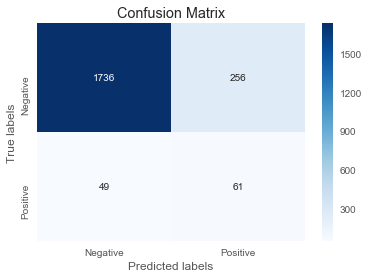

In [863]:
def PlotConfusionMatrix(x):
    ax= plt.subplot()
    sns.heatmap(x, annot=True, cmap='Blues',ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

PlotConfusionMatrix(cm)

In [864]:
feature_importances_rf = pd.DataFrame(rfc.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',                                                                 
                                                                        ascending=False)

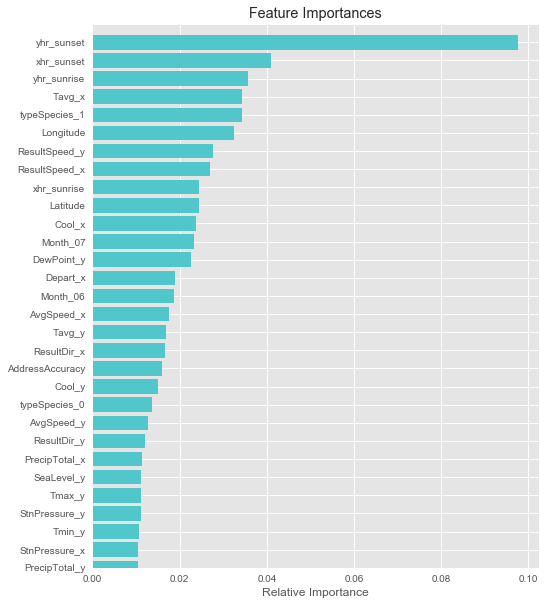

In [866]:
# feature importance plot
importances_rf = rfc.best_estimator_.feature_importances_
indices_rf = np.argsort(importances_rf)

plt.figure(figsize=(8,10))
plt.title('Feature Importances')
#plt.barh(range(len(indices_rf)), importances_rf[indices_rf], color='#51C7CB')
#plt.yticks(range(len(indices_rf)),names[indices_rf])
plt.xlabel('Relative Importance')

top_n =30
plt.barh(np.arange(top_n), importances_rf[indices_rf[-top_n:]],color='#51C7CB')

plt.yticks(np.arange(top_n), X_train.columns[indices_rf[-top_n:]])
plt.ylim(0, top_n)

plt.show()

### XGBoost

In [882]:
xgb_classifer =XGBClassifier(n_estimators=5,seed=42)

grid_xgb = {#'min_child_weight': [1, 5, 10],
        #'colsample_bytree': [0.8, 1.0, 1.2],
        'subsample': [0.6, 0.8,1],
        'max_depth': [5,10,15],
        'learning_rate': [0.1,0.2,0.3]
            
}

xgb = GridSearchCV(estimator=xgb_classifer, param_grid =grid_xgb,cv=6) 

In [883]:
xgb.fit(X_train_res, y_train_res)

GridSearchCV(cv=6, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=5,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 10, 15], 'subsample': [0.6, 0.8, 1], 'learning_rate': [0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [884]:
xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=15, min_child_weight=1, missing=None, n_estimators=5,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [963]:
pred_xgb = xgb.best_estimator_.fit(X_train_res, y_train_res).predict(np.array(X_valid))

print('False Negative in valid data: ',confusion_matrix(y_valid, pred_xgb).ravel()[2])
print('Confusion Matrix: ',confusion_matrix(y_valid, pred_xgb))

False Negative in valid data:  59
Confusion Matrix:  [[1798  194]
 [  59   51]]


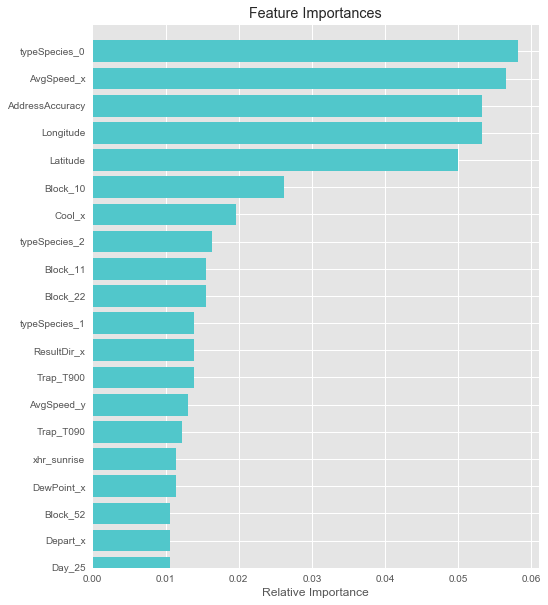

In [886]:
# feature importance plot
importances_xgb = xgb.best_estimator_.feature_importances_
indices_xgb = np.argsort(importances_xgb)

plt.figure(figsize=(8,10))
plt.title('Feature Importances')
#plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], color='#51C7CB')
#plt.yticks(range(len(indices_xgb)),names[indices_xgb])
plt.xlabel('Relative Importance')

top_n =20
plt.barh(np.arange(top_n), importances_xgb[indices_xgb[-top_n:]],color='#51C7CB')

plt.yticks(np.arange(top_n), X_train.columns[indices_xgb[-top_n:]])
plt.ylim(0, top_n)
plt.show()

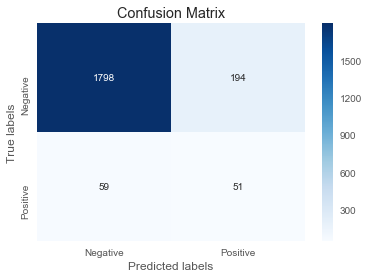

In [887]:
def PlotConfusionMatrix(x):
    ax= plt.subplot()
    sns.heatmap(x, annot=True, cmap='Blues',ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

PlotConfusionMatrix(confusion_matrix(y_valid, pred_xgb))

Logistic Regression AUC:0.8154276195691859 
RandomForest AUC:0.8415274735304855 
Decision Tree AUC:0.7869569185834245 
XGBoost AUC:0.8189804673238409 


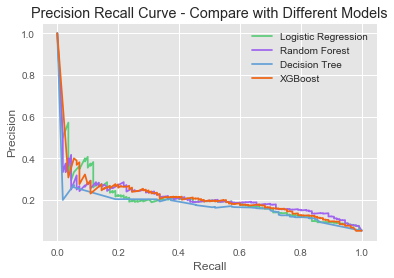

In [888]:
#precision -recall

pred_lr_c = lr.best_estimator_.fit(X_train_res, y_train_res).predict_proba(X_valid)
pred_dt_c = dt.best_estimator_.fit(X_train_res, y_train_res).predict_proba(X_valid)
pred_rfc_c = rfc.best_estimator_.fit(X_train_res, y_train_res).predict_proba(X_valid)
pred_xgb_c = xgb.best_estimator_.fit(X_train_res, y_train_res).predict_proba(np.array(X_valid))

p_lr_c, r_lr_c, t_lr_c = precision_recall_curve(y_valid,pred_lr_c[:,1])
p_rfc_c, r_rfc_c, t_rfc_c = precision_recall_curve(y_valid,pred_rfc_c[:,1])
p_dtc_c, r_dtc_c, t_dtc_c = precision_recall_curve(y_valid,pred_dt_c[:,1])
p_xgb_c, r_xgb_c, t_xgb_c = precision_recall_curve(y_valid,pred_xgb_c[:,1])

plt.plot(r_lr_c,p_lr_c,label='Logistic Regression',color="#5CCD7A")
plt.plot(r_rfc_c,p_rfc_c,label='Random Forest',color ="#A064EF")
plt.plot(r_dtc_c,p_dtc_c,label='Decision Tree',color ="#64A1D7")
plt.plot(r_xgb_c,p_xgb_c,label='XGBoost',color ="#F06514")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision Recall Curve - Compare with Different Models')
plt.legend()

print("Logistic Regression AUC:{0} ".format(roc_auc_score(y_valid,pred_lr_c[:,1])))
print("RandomForest AUC:{0} ".format(roc_auc_score(y_valid,pred_rfc_c[:,1])))
print("Decision Tree AUC:{0} ".format(roc_auc_score(y_valid,pred_dt_c[:,1])))
print("XGBoost AUC:{0} ".format(roc_auc_score(y_valid,pred_xgb_c[:,1])))

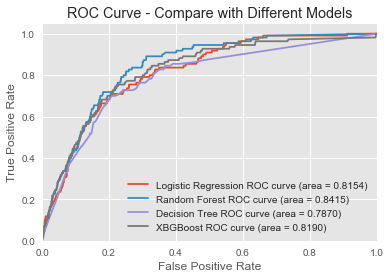

In [889]:
# Plot of a ROC curve for a specific class
# Determine the false positive and true positive rates
fpr_lrc_c, tpr_lrc_c, _lrc_c = roc_curve(y_valid,pred_lr_c[:,1])
fpr_rfc_c, tpr_rfc_c, _rfc_c = roc_curve(y_valid,pred_rfc_c[:,1])
fpr_dtc_c, tpr_dtc_c, _dtc_c = roc_curve(y_valid,pred_dt_c[:,1])
fpr_xgb_c, tpr_xgb_c, _xgb_c = roc_curve(y_valid,pred_xgb_c[:,1])

# Calculate the AUC
roc_auc_lrc_c = auc(fpr_lrc_c, tpr_lrc_c)
roc_auc_rfc_c = auc(fpr_rfc_c, tpr_rfc_c)
roc_auc_dtc_c = auc(fpr_dtc_c, tpr_dtc_c)
roc_auc_xgb_c = auc(fpr_xgb_c, tpr_xgb_c)


plt.figure()

plt.plot(fpr_lrc_c, tpr_lrc_c, label='Logistic Regression ROC curve (area = %0.4f)' % roc_auc_lrc_c)
plt.plot(fpr_rfc_c, tpr_rfc_c, label='Random Forest ROC curve (area = %0.4f)' % roc_auc_rfc_c)
plt.plot(fpr_dtc_c, tpr_dtc_c, label='Decision Tree ROC curve (area = %0.4f)' % roc_auc_dtc_c)
plt.plot(fpr_xgb_c, tpr_xgb_c, label='XBGBoost ROC curve (area = %0.4f)' % roc_auc_xgb_c)

#plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Compare with Different Models')
plt.legend(loc="lower right")
plt.show()

In [890]:
dt_f1 =f1_score(y_valid, pred_dt, average='macro')
rf_f1 =f1_score(y_valid, pred_rfc, average='macro')
xg_f1 =f1_score(y_valid, pred_xgb, average='macro')
lr_f1 =f1_score(y_valid, pred_lr, average='macro')

print('Logistic Regression F1 score: ',lr_f1)
print('Decsion Tree F1 score: ',dt_f1)
print('Random Forest F1 score: ',rf_f1)
print('XGBoost F1 score: ',xg_f1)

Logistic Regression F1 score:  0.524895449096
Decsion Tree F1 score:  0.581216504293
Random Forest F1 score:  0.602481183101
XGBoost F1 score:  0.610796292434


### Summary
F1 Score Table

|Model              |F1 Score    |
|-------------------|:-----------|
|Logistic Regression|0.5248      |
|Decision Tree      |0.5812      |
|Random Forest      |0.6024      |
|XGBoost            |0.6107      |

In [418]:
#Try: feature selection -score testing

xgb_best = best_model
xgb_best.fit(X_train_res,y_train_res)

fs = SelectFromModel(xgb_best, threshold=0.001,prefit=True)

X_train_new = fs.transform(X_train_res) #column selected
X_valid_new = fs.transform(X_valid)

In [419]:
X_train_new.shape

(15926, 149)

In [423]:
xgb_best.fit(X_train_new, y_train_res)

p1 =xgb_best.predict(np.array(X_valid_new))
p2 =xgb_best.predict_proba(np.array(X_valid_new))

print('False Negative in valid data: ',confusion_matrix(y_valid, p1).ravel()[2])
print('Feature Selection F1 Score:', f1_score(y_valid, p1, average='macro'))

pred_xgb_new = xgb_best.fit(X_train_new, y_train_res).predict_proba(np.array(X_valid_new))
print("XGBoost AUC:{0} ".format(roc_auc_score(y_valid,pred_xgb_new[:,1])))

False Negative in valid data:  81
Feature Selection F1 Score: 0.605128120623
XGBoost AUC:0.8094879518072289 


## Future Work

* Need to continuely conduct parameter tuning for XGBoost model
* Try LightGBM to speed up computing
* Try Complexity Neural Networks

## Predict NEW Test Data

### - Probability of WnvPresent

In [652]:
# best model pick up
best_model =xgb.best_estimator_
#save best model
filename = 'bestmodel.pkl'
joblib.dump(best_model, filename)

['bestmodel.pkl']

In [362]:
# test load the model from drive
best_model = joblib.load(filename)

In [359]:
X_test =test5.copy().drop(['WnvPresent'],1)

In [399]:
X_test.shape

(116293, 287)

In [366]:
pred_test = best_model.predict_proba(np.array(X_test))

In [367]:
user_id =X_test.index.values.tolist()

In [369]:
#save predicted column as CSV file
prediction =pd.DataFrame({'Id': user_id ,'WnvPresent':pred_test[:,1]}).to_csv('submission.csv',index = False)